(webscraping-and-apis)=
# Webscraping and APIs

## Introduction

This chapter will show you how to work with online data that is either obtained from webpages via webscraping or more directly over the internet via an API. An important principle is always to use an API if one is available as this is designed to pass information directly into your Python session and will save you a lot of effort.

In [1]:
# remove cell
import matplotlib_inline.backend_inline
import matplotlib.pyplot as plt

# Plot settings
plt.style.use("https://github.com/aeturrell/python4DS/raw/main/plot_style.txt")
matplotlib_inline.backend_inline.set_matplotlib_formats("svg")

### Ethical and legal considerations

As we've already said, you should use an API whenever you can. But, for the cases when you can't, what are the rules of the game when it comes to webscraping? First, we need to talk about whether it’s legal and ethical for you to do so. Overall, the situation is complicated with regards to both of these.

Legalities depend a lot on where you live. However, as a general principle, if the data is public, non-personal, non-commercial, and factual, you’re likely to be ok. These three factors are important because they’re connected to the site’s terms and conditions, personally identifiable information, and copyright, as we’ll discuss below.

If the data isn’t public, non-personal, or factual or you’re scraping the data specifically to make money with it, or you're scraping something that is only available commercially, you’ll need to talk to a lawyer. In any case, you should be respectful of the resources of the server hosting the pages you are scraping. Most importantly, this means that if you’re scraping many pages, you should make sure to wait a little between each request. [Tenacity](https://tenacity.readthedocs.io/en/latest/) is an excellent package for this—it has a function that pauses between attempts to do something (as well as a bunch of other useful features).

If you look closely, you’ll find many websites include a “terms and conditions” or “terms of service” link somewhere on the page, and if you read that page closely you’ll often discover that the site specifically prohibits web scraping. These pages tend to be a legal land grab where companies make very broad claims. It’s polite to respect these terms of service where possible, but take any claims with a grain of salt.

US courts have generally found that simply putting the terms of service in the footer of the website isn’t sufficient for you to be bound by them, e.g., [HiQ Labs v. LinkedIn](https://en.wikipedia.org/wiki/HiQ_Labs_v._LinkedIn). Generally, to be bound to the terms of service, you must have taken some explicit action like creating an account or checking a box. This is why whether or not the data is **public** is important; if you don’t need an account to access them, it is unlikely that you are bound to the terms of service. Note, however, the situation is rather different in Europe where courts have found that terms of service are enforceable even if you don’t explicitly agree to them.

Even if the data is public, you should be extremely careful about scraping personally identifiable information like names, email addresses, phone numbers, dates of birth, etc. Europe has strict laws about the collection or storage of such data (known as GDPR), and regardless of where you live you’re likely to be entering an ethical quagmire. For example, in 2016, a group of researchers scraped public profile information (e.g., usernames, age, gender, location, etc.) about 70,000 people on the dating site OkCupid and they publicly released these data without any attempts at anonymisation. While the researchers felt that there was nothing wrong with this since the data were already public, this work was widely condemned due to ethics concerns around identifiability of users whose information was released in the dataset. If your work involves scraping personally identifiable information, we strongly recommend reading about the OkCupid study3 as well as similar studies with questionable research ethics involving the acquisition and release of personally identifiable information.

Finally, you also need to worry about copyright law. Copyright law is complicated. US law describes exactly what’s protected: “[…] original works of authorship fixed in any tangible medium of expression, […]”. It then goes on to describe specific categories that it applies like literary works, musical works, motion pictures and more. Notably absent from copyright protection are data. This means that as long as you limit your scraping to facts, copyright protection does not apply. (But note that Europe has a separate “sui generis” right that protects databases.)

As a brief example, in the US, lists of ingredients and instructions are not copyrightable, so copyright can not be used to protect a recipe. But if that list of recipes is accompanied by substantial novel literary content, that is copyrightable. This is why when you’re looking for a recipe on the internet there’s always so much content beforehand.

If you do need to scrape original content (like text or images), you may still be protected under the doctrine of fair use. Fair use is not a hard and fast rule, but weighs up a number of factors. It’s more likely to apply if you are collecting the data for research or non-commercial purposes and if you limit what you scrape to just what you need.

### Prerequisites

You will need to install the **pandas** package for this chapter. We'll use **seaborn** too, which you should already have installed. You will also need to install the **beautifulsoup** and **pandas-datareader** packages in your terminal using `pip install beautifulsoup4` and `pip install pandas-datareader` respectively. We'll also use two built-in packages, **textwrap** and **requests**.

To kick off, let's import some of the packages we need (it's always good practice to import the packages you need at the top of a script or notebook).

In [2]:
import requests
import textwrap
import pandas as pd
from bs4 import BeautifulSoup
from lets_plot import *

LetsPlot.setup_html()

## Extracting Data from Files on the Internet using **pandas**

It's easy to read data from the internet once you have the url and file type. Here, for instance, is an example that reads in the 'storms' dataset, which is stored as a CSV file in a URL (we'll only grab the first 10 rows):

In [3]:
pd.read_csv(
    "https://vincentarelbundock.github.io/Rdatasets/csv/dplyr/storms.csv", nrows=10
)

,rownames,name,year,month,day,hour,lat,long,status,category,wind,pressure,tropicalstorm_force_diameter,hurricane_force_diameter
0,1,Amy,1975,6,27,0,27.5,-79.0,tropical depression,NaN,25,1013,NaN,NaN
1,2,Amy,1975,6,27,6,28.5,-79.0,tropical depression,NaN,25,1013,NaN,NaN
2,3,Amy,1975,6,27,12,29.5,-79.0,tropical depression,NaN,25,1013,NaN,NaN
3,4,Amy,1975,6,27,18,30.5,-79.0,tropical depression,NaN,25,1013,NaN,NaN
4,5,Amy,1975,6,28,0,31.5,-78.8,tropical depression,NaN,25,1012,NaN,NaN
5,6,Amy,1975,6,28,6,32.4,-78.7,tropical depression,NaN,25,1012,NaN,NaN
6,7,Amy,1975,6,28,12,33.3,-78.0,tropical depression,NaN,25,1011,NaN,NaN
7,8,Amy,1975,6,28,18,34.0,-77.0,tropical depression,NaN,30,1006,NaN,NaN
8,9,Amy,1975,6,29,0,34.4,-75.8,tropical storm,NaN,35,1004,NaN,NaN
9,10,Amy,1975,6,29,6,34.0,-74.8,tropical storm,NaN,40,1002,NaN,NaN


## Obtaining data using APIs

Using an API (application programming interface) is another way to draw down information from the interweb. Their just a way for one tool, say Python, to speak to another tool, say a server, and usefully exchange information. The classic use case would be to post a request for data that fits a certain query via an API and to get a download of that data back in return. (You should always preferentially use an API over webscraping a site.)

Because they are designed to work with any tool, you don't actually need a programming language to interact with an API, it's just a *lot* easier if you do.

```{note}
An API key is needed in order to access some APIs. Sometimes all you need to do is register with site, in other cases you may have to pay for access.
```

To see this, let's directly use an API to get some time series data. We will make the call out to the internet using the **requests** package.

An API has an 'endpoint', the base url, and then a URL that encodes the question. Let's see an example with the ONS API for which the endpoint is "https://api.ons.gov.uk/". The rest of the API has the form 'key/value', for example we'll ask for timeseries data 'timeseries' followed by 'JP9Z' for the vacancies in the UK services sector. We then ask for 'dataset' followed by 'UNEM' to specify which overarching dataset the series we want is in. The last part asks for the data with 'data'. Often you won't need to know all of these details, but it's useful to see a detailed example.

The data that are returned by APIs are typically in JSON format, which looks a lot like a nested Python dictionary and its entries can be accessed in the same way--this is what is happening when getting the series' title in the example below. JSON is not good for analysis, so we'll use **pandas** to put the data into shape.

/var/folders/x6/ffnr59f116l96_y0q0bjfz7c0000gn/T/ipykernel_23778/2065280636.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  date=lambda x: pd.to_datetime(x["date"]),


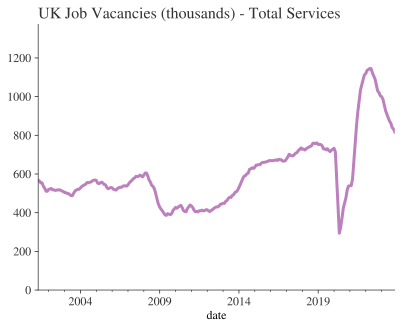

In [4]:
url = "https://api.ons.gov.uk/timeseries/JP9Z/dataset/UNEM/data"

# Get the data from the ONS API:
json_data = requests.get(url).json()

# Prep the data for a quick plot
title = json_data["description"]["title"]
df = (
    pd.DataFrame(pd.json_normalize(json_data["months"]))
    .assign(
        date=lambda x: pd.to_datetime(x["date"]),
        value=lambda x: pd.to_numeric(x["value"]),
    )
    .set_index("date")
)

df["value"].plot(title=title, ylim=(0, df["value"].max() * 1.2), lw=3.0);

We've talked about *reading* APIs. You can also create your own to serve up data, models, whatever you like! This is an advanced topic and we won't cover it; but if you do need to, the simplest way is to use [Fast API](https://fastapi.tiangolo.com/). You can find some short video tutorials for Fast API [here](https://calmcode.io/fastapi/hello-world.html).

### Pandas Datareader: an easier way to interact with (some) APIs

Although it didn't take much code to get the ONS data, it would be even better if it was just a single line, wouldn't it? Fortunately there are some packages out there that make this easy, but it does depend on the API (and APIs come and go over time).

By far the most comprehensive library for accessing extra APIs is [**pandas-datareader**](https://pandas-datareader.readthedocs.io/en/latest/), which provides convenient access to:

- FRED
- Quandl
- World Bank
- OECD
- Eurostat

and more.

Let's see an example using FRED (the Federal Reserve Bank of St. Louis' economic data library). This time, let's look at the UK unemployment rate:

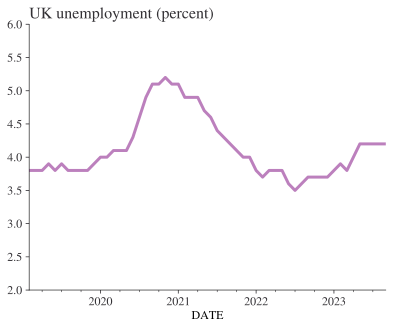

In [5]:
import pandas_datareader.data as web

df_u = web.DataReader("LRHUTTTTGBM156S", "fred")

df_u.plot(title="UK unemployment (percent)", legend=False, ylim=(2, 6), lw=3.0);

And, because it's also a really useful one, let's also see how to use **pandas-datareader** to access World Bank data.

In [6]:
# World Bank CO2 emissions (metric tons per capita)
# https://data.worldbank.org/indicator/EN.ATM.CO2E.PC
# World Bank pop
# https://data.worldbank.org/indicator/SP.POP.TOTL
# country and region codes at http://api.worldbank.org/v2/country
from pandas_datareader import wb

df = wb.download(
    indicator="EN.ATM.CO2E.PC",
    country=["US", "CHN", "IND", "Z4", "Z7"],
    start=2017,
    end=2017,
)
# remove country as index for ease of plotting with seaborn
df = df.reset_index()
# wrap long country names
df["country"] = df["country"].apply(lambda x: textwrap.fill(x, 10))
# order based on size
df = df.sort_values("EN.ATM.CO2E.PC")
df.head()

/Users/aet/mambaforge/envs/py4ds2e/lib/python3.10/site-packages/pandas_datareader/wb.py:592: UserWarning: Non-standard ISO country codes: Z4, Z7
  warnings.warn(


,country,year,EN.ATM.CO2E.PC
3,India,2017,1.704927
1,East Asia\n& Pacific,2017,5.960076
2,Europe &\nCentral\nAsia,2017,6.746232
0,China,2017,7.226160
4,United\nStates,2017,14.823245


In [7]:
(
    ggplot(df, aes(x="country", y="EN.ATM.CO2E.PC"))
    + geom_bar(aes(fill="country"), color="black", alpha=0.8, stat="identity")
    + scale_fill_discrete()
    + theme_minimal()
    + theme(legend_position="none")
    + ggsize(600, 400)
    + labs(
        subtitle="Carbon dioxide (metric tons per capita)",
        title="The USA leads the world on per-capita emissions",
        y="",
    )
)

### The OECD API

Sometimes it's convenient to use APIs directly, and, as an example, the OECD API comes with a LOT of complexity that direct access can take advantage of. The OECD API makes data available in both JSON and XML formats, and we'll use [**pandasdmx**](https://pandasdmx.readthedocs.io/) (aka the Statistical Data and Metadata eXchange (SDMX) package for the Python data ecosystem) to pull down the XML format data and turn it into a regular **pandas** data frame.

Now, key to using the OECD API is knowledge of its many codes: for countries, times, resources, and series. You can find some broad guidance on what codes the API uses [here](https://data.oecd.org/api/sdmx-ml-documentation/) but to find exactly what you need can be a bit tricky. Two tips are:
1. If you know what you're looking for is in a particular named dataset, eg "QNA" (Quarterly National Accounts), put `https://stats.oecd.org/restsdmx/sdmx.ashx/GetDataStructure/QNA/all?format=SDMX-ML` into your browser and look through the XML file; you can pick out the sub-codes and the countries that are available.
2. Browse around on https://stats.oecd.org/ and use Customise then check all the "Use Codes" boxes to see whatever your browsing's code names.

Let's see an example of this in action. We'd like to see the productivity (GDP per hour) data for a range of countries since 2010. We are going to be in the productivity resource (code "PDB_LV") and we want the USD current prices (code "CPC") measure of GDP per employed worker (code "T_GDPEMP) from 2010 onwards (code "startTime=2010"). We'll grab this for some developed countries where productivity measurements might be slightly more comparable. The comments below explain what's happening in each step.

```python
import pandasdmx as pdmx
# Tell pdmx we want OECD data
oecd = pdmx.Request("OECD")
# Set out everything about the request in the format specified by the OECD API
data = oecd.data(
    resource_id="PDB_LV",
    key="GBR+FRA+CAN+ITA+DEU+JPN+USA.T_GDPEMP.CPC/all?startTime=2010",
).to_pandas()

df = pd.DataFrame(data).reset_index()
df.head()
```

|   | LOCATION |  SUBJECT | MEASURE | TIME_PERIOD |        value |
|--:|---------:|---------:|--------:|------------:|-------------:|
| 0 |      CAN | T_GDPEMP |     CPC |        2010 | 78848.604088 |
| 1 |      CAN | T_GDPEMP |     CPC |        2011 | 81422.364748 |
| 2 |      CAN | T_GDPEMP |     CPC |        2012 | 82663.028058 |
| 3 |      CAN | T_GDPEMP |     CPC |        2013 | 86368.582158 |
| 4 |      CAN | T_GDPEMP |     CPC |        2014 | 89617.632446 |

Great that worked! We have data in a nice tidy format.

### Other Useful APIs

- There is a regularly updated list of APIs over at this [public APIs repo on github](https://github.com/public-apis/public-apis). It doesn't have an economics section (yet), but it has a LOT of other APIs.
- Berkeley Library maintains a [list of economics APIs](https://guides.lib.berkeley.edu/c.php?g=4395&p=7995952) that is well worth looking through.
- [NASDAQ Data Link](https://docs.data.nasdaq.com/), which has a great deal of [financial data](https://docs.data.nasdaq.com/docs/data-organization).
- [DBnomics](https://db.nomics.world/): publicly-available economic data provided by national and international statistical institutions, but also by researchers and private companies.

## Webscraping

Webscraping is a way of grabbing information from the internet that was intended to be displayed in a browser. But it should only be used as a last resort, and only then when permitted by the terms and conditions of a website.

If you're getting data from the internet, it's much better to use an API whenever you can: grabbing information in a structure way is *exactly* why APIs exist. APIs should also be more stable than websites, which may change frequently. Typically, if an organisation is happy for you to grab their data, they will have made an API expressly for that purpose. It's pretty rare that there's a major website which *does* permit webscraping but which doesn't have an API; for these websites, if they don't have an API, chances scraping is against their terms and conditions. Those terms and conditions may be enforceable by law (different rules in different countries here, and you really need legal advice if it's not unambiguous as to whether you can scrape or not.)

There are other reasons why webscraping is not so good; for example, if you need a back-run then it might be offered through an API but not shown on the webpage. (Or it might not be available at all, in which case it's best to get in touch with the organisation or check out WaybackMachine in case they took snapshots).

So this book is pretty down on webscraping as there's almost always a better solution. However, there are times when it is useful.

If you do find yourself in a scraping situation, be really sure to check that's legally allowed and also that you are not violating the website's `robots.txt` rules: this is a special file on almost every website that sets out what's fair play to crawl (conditional on legality) and what robots should not go poking around in.

In Python, you are spoiled for choice when it comes to webscraping. There are five very strong libraries that cover a real range of user styles and needs: **requests**, **lxml**, **beautifulsoup**, **selenium**, and *scrapy**.

For quick and simple webscraping, my usual combo would **requests**, which does little more than go and grab the HTML of a webpage, and **beautifulsoup**, which then helps you to navigate the structure of the page and pull out what you're actually interested in. For dynamic webpages that use javascript rather than just HTML, you'll need **selenium**. To scale up and hit thousands of webpages in an efficient way, you might try **scrapy**, which can work with the other tools and handle multiple sessions, and all other kinds of bells and whistles... it's actually a "web scraping framework".

It's always helpful to see coding in practice, so that's what we'll do now, but note that we'll be skipping over a lot of important detail such as user agents, being 'polite' with your scraping requests, being efficient with caching and crawling.

In lieu of a better example, let's scrape the research page of [http://aeturrell.com/](http://aeturrell.com/)

In [8]:
url = "http://aeturrell.com/research"
page = requests.get(url)
page.text[:300]

'<!DOCTYPE html>\n<html xmlns="http://www.w3.org/1999/xhtml" lang="en" xml:lang="en"><head>\n\n<meta charset="utf-8">\n<meta name="generator" content="quarto-1.3.361">\n\n<meta name="viewport" content="width=device-width, initial-scale=1.0, user-scalable=yes">\n\n<meta name="author" content="Arthur Turrell">'

Okay, what just happened? We asked requests to grab the HTML of the webpage and then printed the first 300 characters of the text that it found.

Let's now parse this into something humans can read (or can read more easily) using beautifulsoup:

In [9]:
soup = BeautifulSoup(page.text, "html.parser")
print(soup.prettify()[60000:60500])

ing-date-modified-sort="NaN" data-listing-date-sort="1640995200000" data-listing-file-modified-sort="1687518448229" data-listing-reading-time-sort="1">
         <div class="project-content listing-pub-info">
          <p>
           Turrell, Arthur, Bradley Speigner, Jyldyz Djumalieva, David Copple, and James Thurgood. "6. Transforming Naturally Occurring Text Data into Economic Statistics." In
           <i>
            Big Data for Twenty-First-Century Economic Statistics
           </i>
     


Now we see more structure of the page and even some *HTML tags* such as 'title' and 'link'. Now we come to the data extraction part: say we want to pull out every paragraph of text, we can use beautifulsoup to skim down the HTML structure and pull out only those parts with the paragraph tag ('p').


In [10]:
# Get all paragraphs
all_paras = soup.find_all("p")
# Just show one of the paras
all_paras[1]

<p>Kalamara, Eleni, Arthur Turrell, Chris Redl, George Kapetanios, and Sujit Kapadia. "Making text count: economic forecasting using newspaper text." <i>Journal of Applied Econometrics</i> 37, no. 5 (2022): 896-919. doi: <a href="https://doi.org/10.1002/jae.2907"><code>10.1002/jae.2907</code></a></p>

Although this paragraph isn't too bad, you can make this more readable by stripping out HTML tags altogether with the `.text` method:

In [11]:
all_paras[1].text

'Kalamara, Eleni, Arthur Turrell, Chris Redl, George Kapetanios, and Sujit Kapadia. "Making text count: economic forecasting using newspaper text." Journal of Applied Econometrics 37, no. 5 (2022): 896-919. doi: 10.1002/jae.2907'

Now let's say we didn't care about most of the page, we *only* wanted to get hold of the names of projects. For this we need to identify the tag type of the element we're interested in, in this case 'div', and it's class type, in this case "project-name". We do it like this (and show nice text in the process):


In [12]:
projects = soup.find_all("div", class_="project-content listing-pub-info")
projects = [x.text.strip() for x in projects]
projects

['Kalamara, Eleni, Arthur Turrell, Chris Redl, George Kapetanios, and Sujit Kapadia. "Making text count: economic forecasting using newspaper text." Journal of Applied Econometrics 37, no. 5 (2022): 896-919. doi: 10.1002/jae.2907',
 'Turrell, A., Speigner, B., Copple, D., Djumalieva, J. and Thurgood, J., 2021. Is the UK’s productivity puzzle mostly driven by occupational mismatch? An analysis using big data on job vacancies. Labour Economics, 71, p.102013. doi: 10.1016/j.labeco.2021.102013',
 'Haldane, Andrew G., and Arthur E. Turrell. "Drawing on different disciplines: macroeconomic agent-based models." Journal of Evolutionary Economics 29 (2019): 39-66. doi: 10.1007/s00191-018-0557-5',
 'Haldane, Andrew G., and Arthur E. Turrell. "An interdisciplinary model for macroeconomics." Oxford Review of Economic Policy 34, no. 1-2 (2018): 219-251. doi: 10.1093/oxrep/grx051',
 'Braun-Munzinger, Karen, Z. Liu, and A. E. Turrell. "An agent-based model of corporate bond trading." Quantitative Fin

Hooray! We managed to get the information we wanted: all we needed to know was the right tags. A good tip for finding the tags of the info you want is to look at in your browser (eg Google Chrome) and then right-click on the bit you're interested in, then hit 'Inspect'. This will show you the HTML element of the bit of the page you clicked on.

That's almost it for this very, very brief introduction to webscraping. We'll just see one more thing: how to iterate over multiple pages.

Imagine we had a root webpage such as "www.codingforeconomists.com" which had subpages such as "www.codingforeconomists.com/page=1", "www.codingforeconomists.com/page=2", and so on. One need only iterate create the HTML strings to pass into a function that scrapes each one and return the relevant data, eg for the first 50 pages, and with a function called `scraper()`, one might run

```
start, stop = 0, 50
root_url = "www.codingforeconomists.com/page="
info_on_pages = [scraper(root_url + str(i)) for i in range(start, stop)]
```

That's all we'll cover here but remember we've barely *scraped* the surface of this big, complex topic. If you want to read about an application, it's hard not to recommend the paper on webscraping that has undoubtedly change the world the most, and very likely has affected your own life in numerous ways: ["The PageRank Citation Ranking: Bringing Order to the Web"](http://ilpubs.stanford.edu:8090/422/) by Page, Brin, Motwani and Winograd. For a more in-depth example of webscraping, check out realpython's [tutorial](https://realpython.com/python-web-scraping-practical-introduction/).

### Webscraping Tables

Often there are times when you don't actually want to scrape an entire webpage and all you want is the data from a *table* within the page. Fortunately, there is an easy way to scrape individual tables using the **pandas** package.

We will read data from the first table on 'https://simple.wikipedia.org/wiki/FIFA_World_Cup' using **pandas**. The function we'll use is `read_html()`, which returns a list of data frames of all the tables it finds when you pass it a URL. If you want to filter the list of tables, use the `match=` keyword argument with text that only appears in the table(s) you're interested in.

The example below shows how this works; looking at the website, we can see that the table we're interested in (of past world cup results), has a 'fourth place' column while other tables on the page do not. Therefore we run:

In [13]:
df_list = pd.read_html(
    "https://simple.wikipedia.org/wiki/FIFA_World_Cup", match="Sweden"
)
# Retrieve first and only entry from list of data frames
df = df_list[0]
df.head()

,Years,Hosts,Winners,Score,Runner's-up,Third place,Score.1,Fourth place
0,1930 Details,Uruguay,Uruguay,4 - 2,Argentina,United States,[note 1],Yugoslavia
1,1934 Details,Italy,Italy,2 - 1,Czechoslovakia,Germany,3 - 2,Austria
2,1938 Details,France,Italy,4 - 2,Hungary,Brazil,4 - 2,Sweden
3,1950 Details,Brazil,Uruguay,2 - 1,Brazil,Sweden,[note 2],Spain
4,1954 Details,Switzerland,West Germany,3 - 2,Hungary,Austria,3 - 1,Uruguay


This gives us the table neatly loaded into a **pandas** data frame ready for further use.